# Project Report

**Outline**
1. Introduction
2. Install and import dependencies
3. Load and preprocess the required dataframes
4. Visualize correlations between weather and audio features  
 4.1. Air temperature  
 4.2. Cloud coverage  
 4.3. Wind speed  
 4.4. Precipitation  
5. Train and evaluate a Random Forest Regressor model to predict a song's popularity (based on weather and audio features)
6. Download and preprocess the latest weather data and trending songs
7. Utilize the RFR to recommend one of the songs
8. Clustering
9. Conclusion and outlook

## 1. Introduction
This project aims to determine if there is a significant correlation between weather and music preferences.  
A second goal is to train a machine learning model that can predict a song's popularity based on weather and audio features. The model is used to recommend a song based on the current weather.

## 2. Install and import dependencies

In [32]:
%%capture
%pip install ftplib
%pip install ipython
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install shutil
%pip install spotipy
%pip install sqlalchemy
%pip install zipfile

In [33]:
import IPython.display as display
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import spotipy
import zipfile

from ftplib import FTP
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabasz_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 3. Load and preprocess the required dataframes

- **cloud_df**
  - bedeckungsgrad: *estimated coverage of the visible sky with clouds in eighths*
- **rain_df**
  - niederschlagshoehe: *precipitation height in mm*
  - schneehoehe_cm: *snow height in cm*
  - neuschneehoehe_cm: *fresh snow height in cm*
- **temperature_df**
  - lufttemperatur: *air temperature in °C*
  - rel_feuchte: *relative humidity in %*
- **wind_df**
  - windstaerke: *wind speed in Bft*
- **songs_df**
  - date: *day of chart observation*
  - position: *1-200 position in charts*
  - track_id: *unique spotify ID for each song*
  - title: *song's title*
  - artist: *song's artist*
- **audio_features_df**
  - see [here](../data/audio_features_meaning.md)

In [34]:
db_uri = "sqlite:///../data.sqlite"

cloud_df = pd.read_sql_table("cloud_data", db_uri, columns=["mess_datum", "bedeckungsgrad"])
rain_df = pd.read_sql_table("rain_data", db_uri, columns=["mess_datum", "niederschlagshoehe_mm", "schneehoehe_cm", "neuschneehoehe_cm"])
temperature_df = pd.read_sql_table("temperature_data", db_uri, columns=["mess_datum", "lufttemperatur", "rel_feuchte"])
wind_df = pd.read_sql_table("wind_data", db_uri, columns=["mess_datum", "windstaerke"])
songs_df = pd.read_sql_table("spotify_data", db_uri, columns=["date", "position", "track_id", "title", "artist"])
audio_features_df = pd.read_sql_table("audio_features", db_uri)

In [35]:
def preprocess(df):
    df.replace(-999, pd.NA, inplace=True)
    df["date"] = pd.to_datetime(df["mess_datum"]).dt.date
    df.drop("mess_datum", axis=1, inplace=True)
    df = df.groupby("date").mean().reset_index()
    return df

songs_df["date"] = pd.to_datetime(songs_df["date"]).dt.date

cloud_df = preprocess(cloud_df)
rain_df = preprocess(rain_df)
temperature_df = preprocess(temperature_df)
wind_df = preprocess(wind_df)

## 4. Visualize correlations between weather and audio features
In this section, I will present some visualizations of the correlations between weather and audio features. Due to the nature of this project, it is not possible to establish causality and determine the precise mechanisms behind the observed correlations. However, we can still make some educated guesses and speculate about the reasons for these correlations.

### 4.1. Air temperature

In [36]:
x_vars = list(audio_features_df.columns.values)
x_vars.remove("track_id")
x_vars.remove("instrumentalness")
x_vars.remove("mode")

def plot_lines(df: pd.DataFrame, audio_feature: str, weather_feature: str, n_bins: int = 20, order: int = 1):
    # Create bins
    df["bin"] = pd.cut(df[weather_feature], n_bins)
    bins = df["bin"].cat.categories
    avg_values = [(bin.left + bin.right) / 2 for bin in bins]
    mean_feature_val_df = df.groupby("bin")[audio_feature].mean().reset_index()

    # Plot the relationship between binned weather feature and mean audio feature value
    plt.figure(figsize=(10, 6))
    plt.plot(avg_values, mean_feature_val_df[audio_feature], marker="o")
    sns.regplot(x=avg_values, y=mean_feature_val_df[audio_feature], marker="o", color=".2", order=order, ci=90,)
    plt.xlabel(weather_feature)
    plt.ylabel(f"Average {audio_feature}")
    plt.title(f"Relationship between {weather_feature} and Mean {audio_feature} of Songs")
    plt.grid(True)
    plt.show()

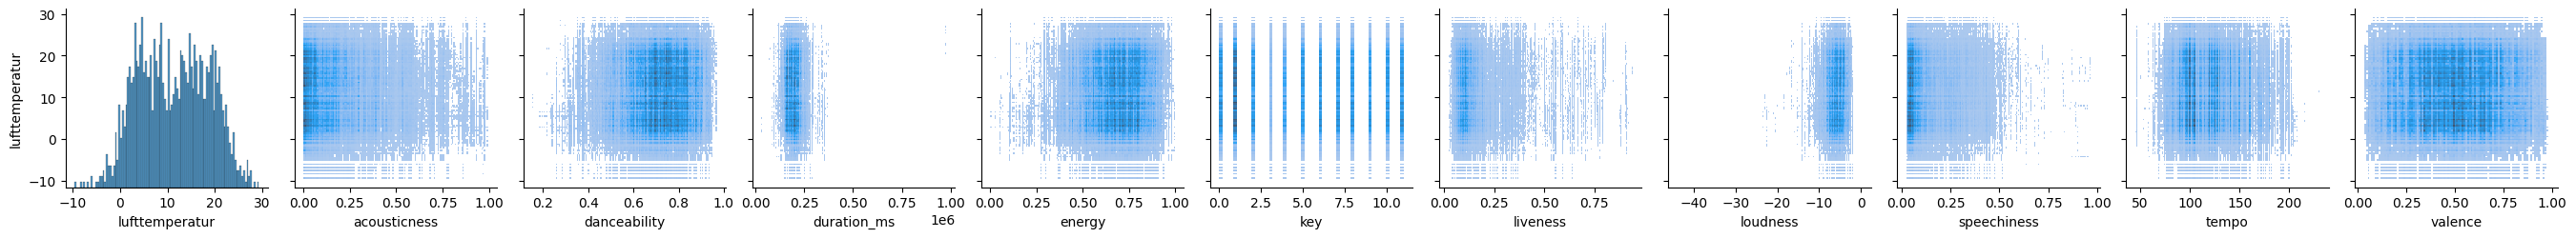

In [37]:
merged_df = temperature_df[["date", "lufttemperatur"]]
merged_df = merged_df.merge(songs_df, on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")
sns.pairplot(merged_df, kind="hist", x_vars=["lufttemperatur"] + x_vars,
             y_vars=["lufttemperatur"])
plt.show()

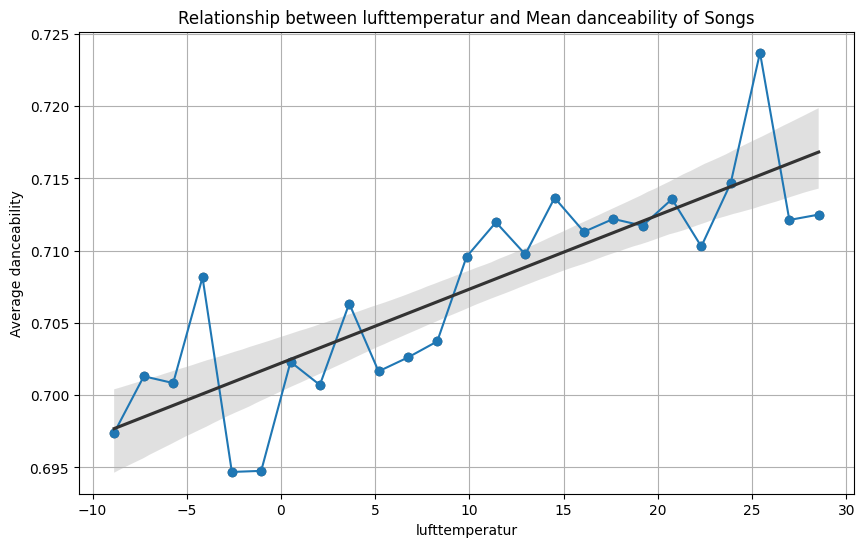

In [38]:
plot_lines(merged_df, "danceability", "lufttemperatur", 25, 1)

The danceability of songs shows a slight correlation with air temperature. Songs tend to be slightly easier to dance to when it is warm outside, which may be attributed to people being more likely to go out and dance in warmer weather.

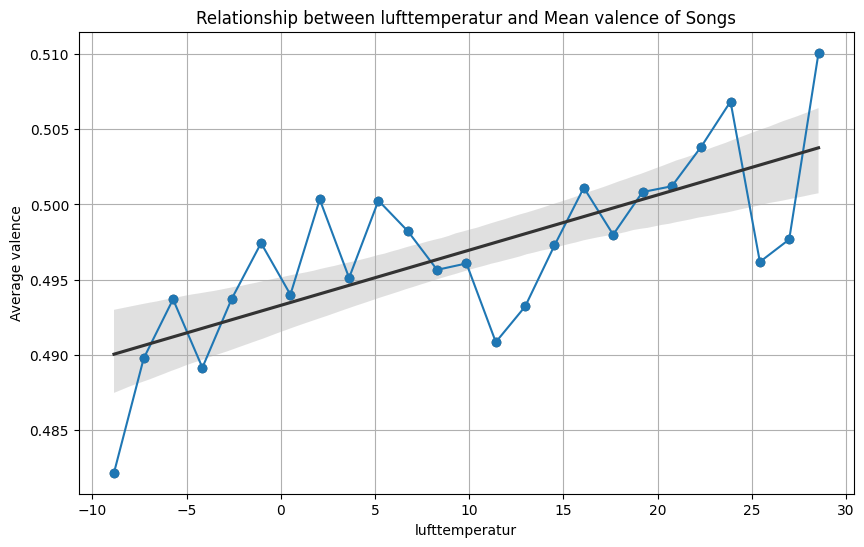

In [39]:
plot_lines(merged_df, "valence", "lufttemperatur", 25, 1)

The valence of songs (positivity) also shows a weak correlation with air temperature, suggesting that people prefer listening to lyrically upbeat songs when it is warm outside. Psychological studies have linked sunlight and warmth to higher levels of serotonin in the brain during summer, which may explain this preference.

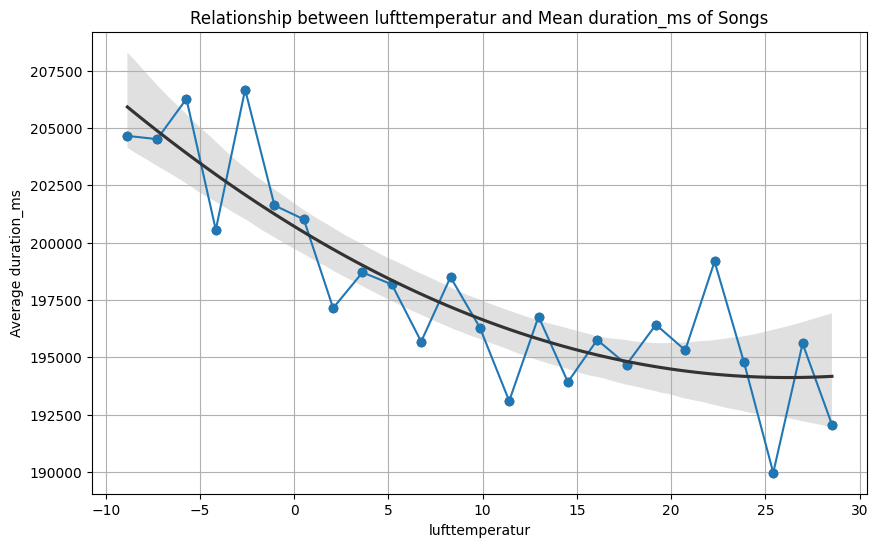

In [40]:
plot_lines(merged_df, "duration_ms", "lufttemperatur", 25, 2)

The graph above illustrates a slight negative correlation between air temperature and song duration. This correlation could be attributed to the music market being especially competitive during the summer season. In an effort to secure more airtime on the radio, artists may opt to release shorter songs. The idea being that radio stations often favor shorter songs so they can accommodate a greater variety of music within their programming schedule.  
As we've seen, songs for hot days tend to be groovy, upbeat and short.

### 4.2. Cloud coverage

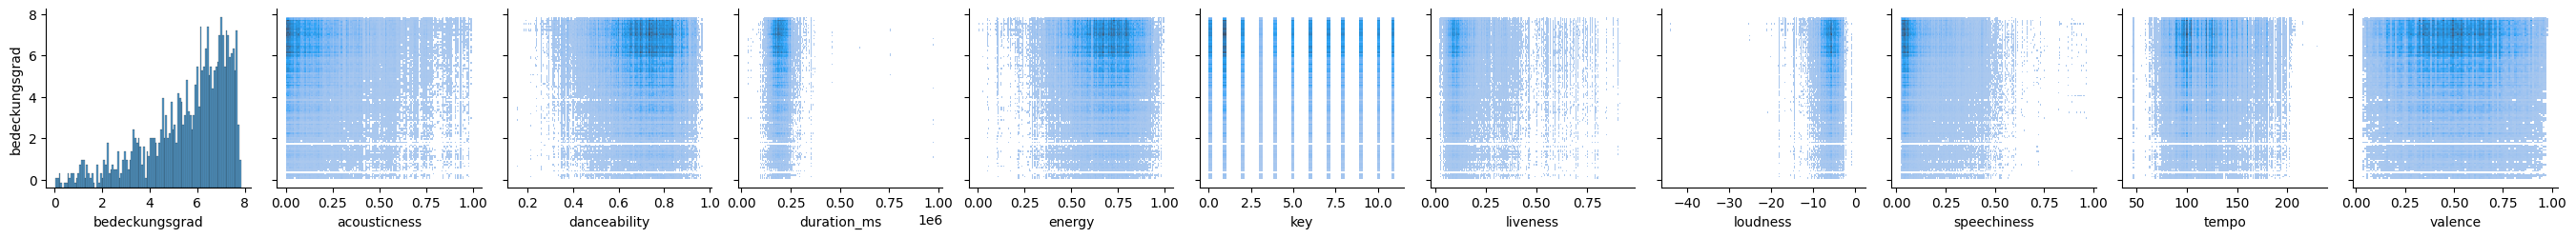

In [41]:
merged_df = cloud_df
merged_df = merged_df.merge(songs_df, on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")
sns.pairplot(merged_df, kind="hist", x_vars=["bedeckungsgrad"] + x_vars, y_vars=["bedeckungsgrad"])
plt.show()

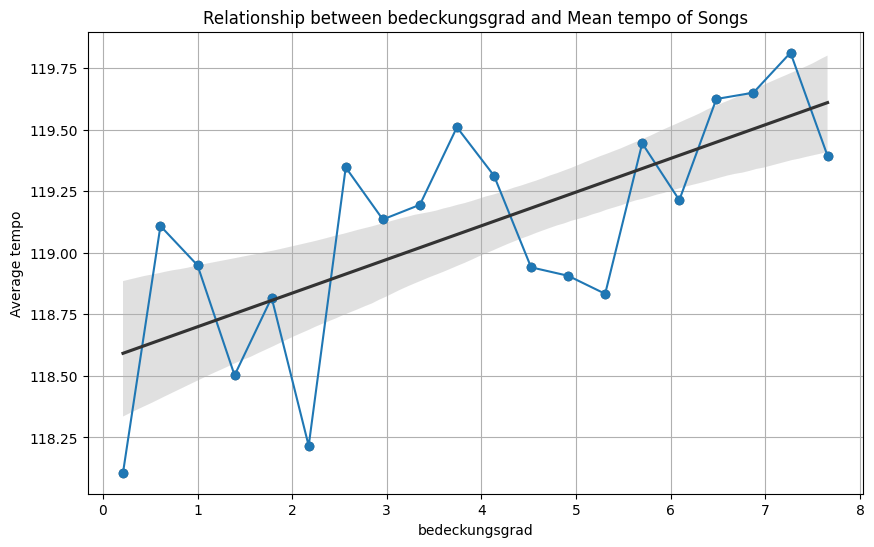

In [42]:
plot_lines(merged_df, "tempo", "bedeckungsgrad")

The visualization shows a faint correlation between the cloud coverage and the tempo of songs. It is likely that the cloud coverage might act as a proxy for the summer season (like the temperature). This would mean that songs with faster beats are preferred during sumer. This aligns with the concept of a "summer song" nicely.

### 4.3 Wind speed

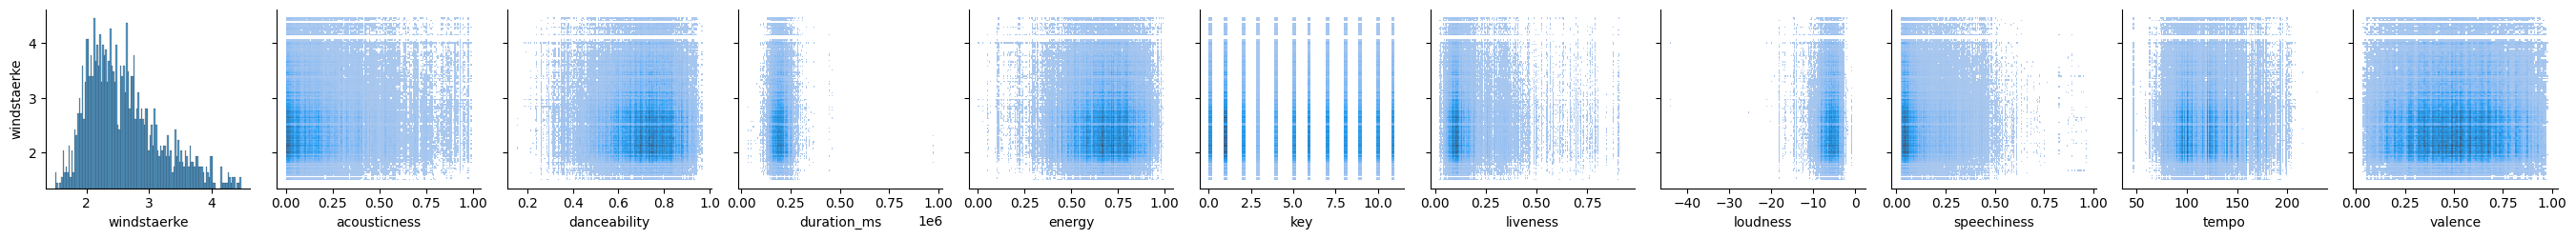

In [43]:
merged_df = wind_df
merged_df = merged_df.merge(songs_df, on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")
merged_df = merged_df[merged_df["windstaerke"] <= 4.5]
sns.pairplot(merged_df, kind="hist", x_vars=["windstaerke"] + x_vars, y_vars=["windstaerke"])
plt.show()

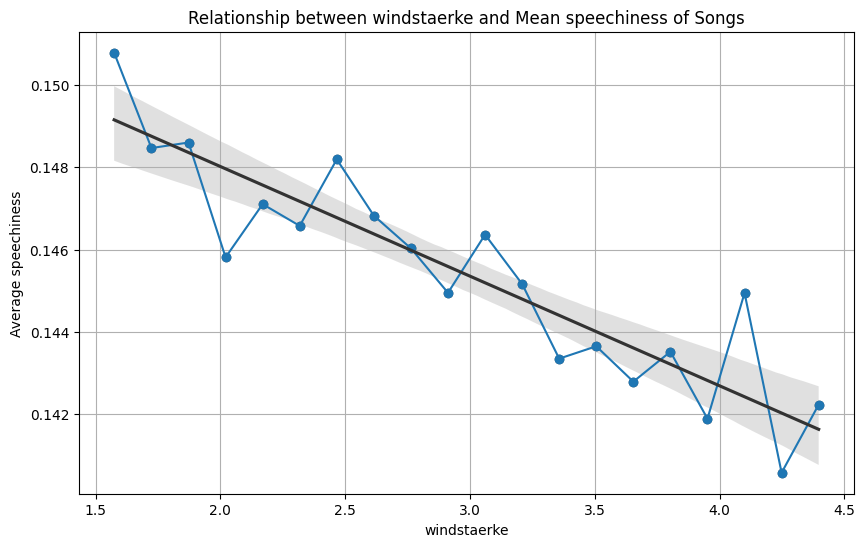

In [44]:
plot_lines(merged_df, "speechiness", "windstaerke")

The graph shows a decline in speechiness (lyrical content) with increasing wind speeds. Perhaps it is too difficult to understand the lyrics of a song when it is stormy outside?

### 4.4. Precipitation

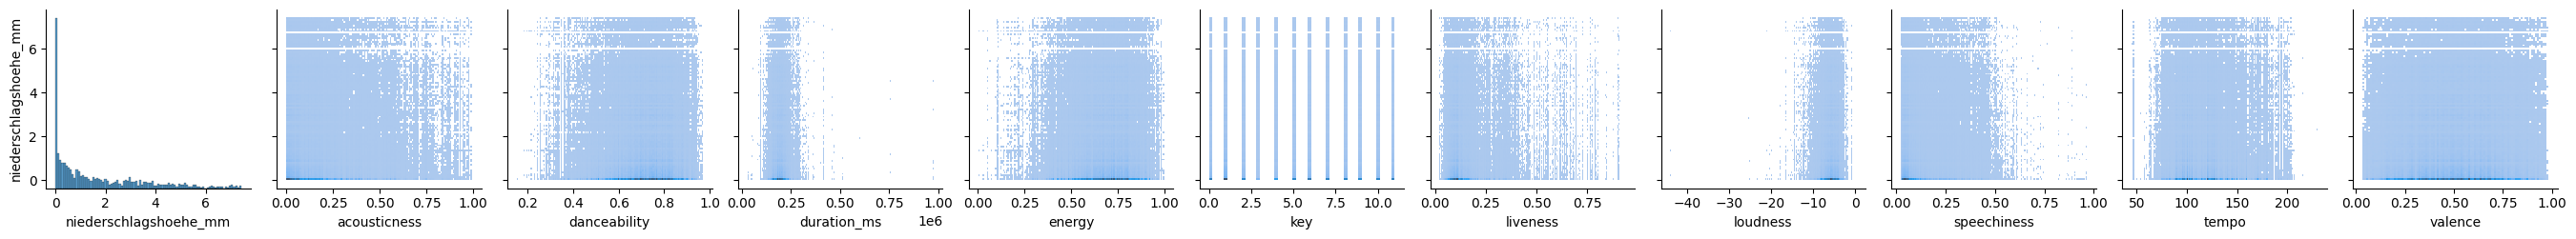

In [45]:
merged_df = rain_df
merged_df = merged_df.merge(songs_df, on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")
merged_df = merged_df[merged_df["niederschlagshoehe_mm"] > 0]
merged_df = merged_df[merged_df["niederschlagshoehe_mm"] <= 7.5]
sns.pairplot(merged_df, kind="hist", x_vars=["niederschlagshoehe_mm"] + x_vars, y_vars=["niederschlagshoehe_mm"])
plt.show()

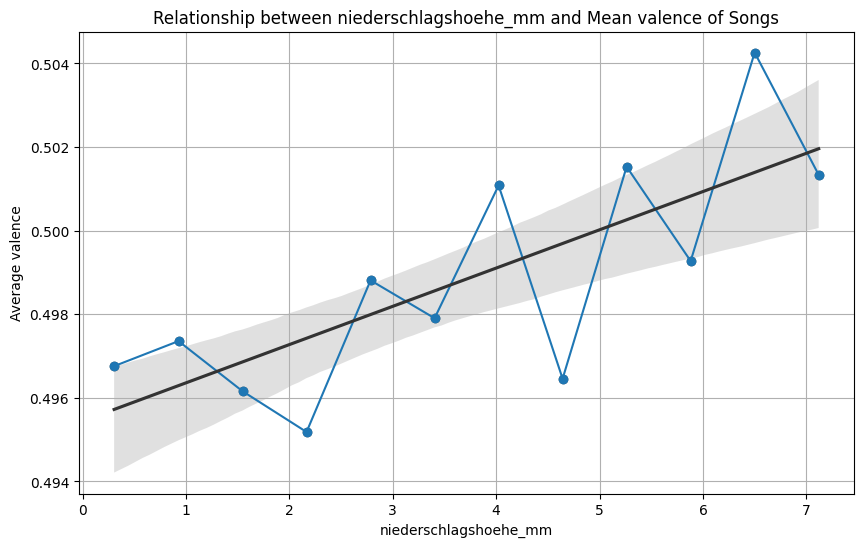

In [46]:
plot_lines(merged_df, "valence", "niederschlagshoehe_mm", 12)

The grap shows a faint correlation between the snow height and the valence of songs. This suggests that people are looking to listen to music that conveys positivity when it is raining outside. This is contradicts this [UK study](https://royalsocietypublishing.org/doi/epdf/10.1098/rsos.221443), which found positive emotions to be negatively associated with rainfall. Maybe we are *Only Happy When It Rains*?

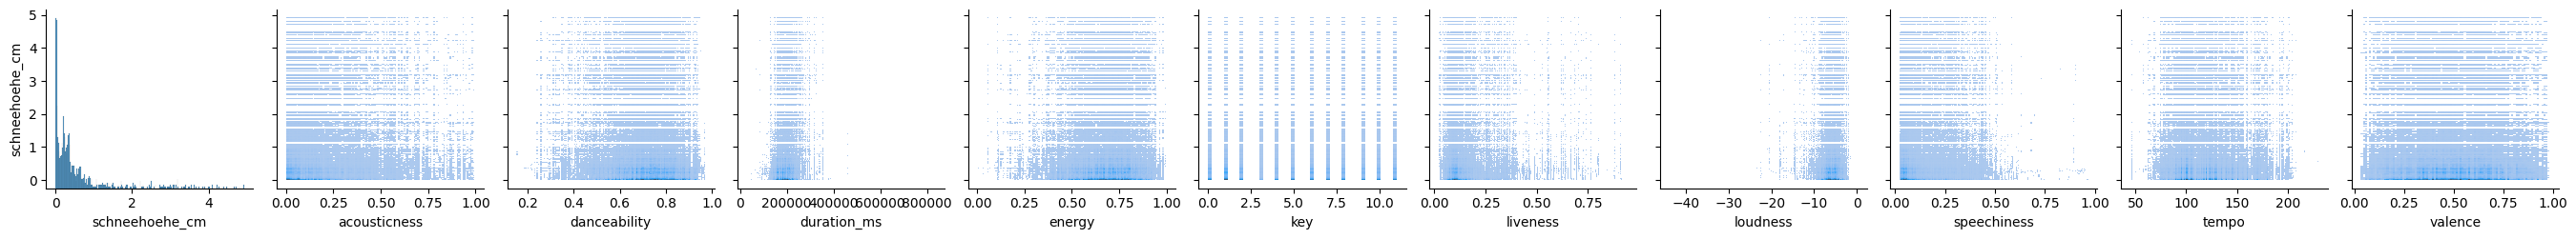

In [47]:
merged_df = rain_df
merged_df = merged_df.merge(songs_df, on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")
merged_df = merged_df[merged_df["schneehoehe_cm"] > 0]
merged_df = merged_df[merged_df["schneehoehe_cm"] <= 5]
sns.pairplot(merged_df, kind="hist", x_vars=["schneehoehe_cm"] + x_vars, y_vars=["schneehoehe_cm"])
plt.show()

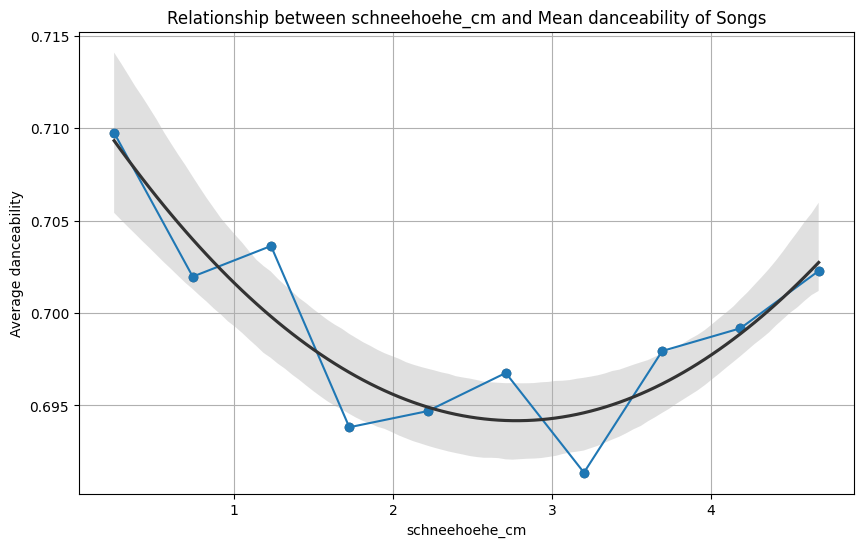

In [48]:
plot_lines(merged_df, "danceability", "schneehoehe_cm", 10, 2)

The plot shows a u-shaped curve, suggesting there is a faint correlation between snow height and the danceability of songs. I could imagine that danceability sinks as we are approaching the dead of winter which fits what we saw with the temperature before. However, The danceability rises again as we are approaching the christmas season which is typically associated with cheerful, danceable music.

It is important to consider that the music industry itself plays a role in shaping consumer expectations and preferences. Consequently, there may not be as much of a causal relationship between weather and music. Instead, it could be a feedback loop where industry analysts create trends in supply, which in turn condition consumers to expect certain attributes in music during certain seasons. This creates a reinforcing cycle between supply and demand.  
In any case, the relationship between weather and music preferences is most likely to be multifaceted, influenced by a combination of elements, including personal, psychological, cultural, and environmental factors.

## 5. Train and evaluate a Random Forest Regressor
In the previous section, we saw there are some patterns in weather phenomena and the type of music people listen to. In this section, I will train a machine learning model, specifically a [Random Forest Regressor](https://en.wikipedia.org/wiki/Random_forest), to predict the popularity of a song based on weather and audio features. The goal is to recommend a song that is likely to be popular on a given day.

- Split data
- Fit RandomForestRegressor
- Evaluate RandomForestRegressor

In [49]:
# split data
merged_df = cloud_df
merged_df = merged_df.merge(rain_df, on="date")
merged_df = merged_df.merge(temperature_df, on="date")
merged_df = merged_df.merge(wind_df, on="date")
merged_df = merged_df.merge(songs_df, on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")

merged_df.dropna(inplace=True)

merged_df["bedeckungsgrad"] = merged_df["bedeckungsgrad"].astype("float64")
merged_df["niederschlagshoehe_mm"] = merged_df["niederschlagshoehe_mm"].astype("float64")
merged_df["schneehoehe_cm"] = merged_df["schneehoehe_cm"].astype("float64")
merged_df["neuschneehoehe_cm"] = merged_df["neuschneehoehe_cm"].astype("float64")
merged_df["lufttemperatur"] = merged_df["lufttemperatur"].astype("float64")
merged_df["rel_feuchte"] = merged_df["rel_feuchte"].astype("float64")
merged_df["windstaerke"] = merged_df["windstaerke"].astype("float64")

merged_df.columns = merged_df.columns.map(str)

x_df = merged_df.drop(["position", "date", "track_id", "title", "artist"], axis=1)
y_df = merged_df["position"]

SEED = 1
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.25, random_state=SEED)

In [50]:
# fit RandomForestRegressor
# parameter tuning guidelines https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters
rfr = RandomForestRegressor(n_estimators=100, max_features=None, max_depth=None, min_samples_split=2, n_jobs=-1, random_state=SEED)
rfr.fit(x_train, y_train)

RandomForestRegressor(max_features=None, n_jobs=-1, random_state=1)

In [51]:
# evaluate RandomForestRegressor
mean_value = 100
y_pred_mean = np.full_like(y_test, mean_value)
mse_mean = mean_squared_error(y_test, y_pred_mean)
print(f"Mean MSE (Baseline):       {mse_mean:>8.2f}  (sqrt: {math.sqrt(mse_mean):>5.2f})")

dtr = tree.DecisionTreeRegressor(max_features=None, max_depth=None, min_samples_split=2, random_state=SEED)
dtr.fit(x_train, y_train)
y_pred_dtr = dtr.predict(x_test)
mse_dtr = mean_squared_error(y_test, y_pred_dtr)
print(f"DecisionTreeRegressor MSE: {mse_dtr:>8.2f}  (sqrt: {math.sqrt(mse_dtr):>5.2f})")

y_pred_rfr = rfr.predict(x_test)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
print(f"RandomForestRegressor MSE: {mse_rfr:>8.2f}  (sqrt: {math.sqrt(mse_rfr):>5.2f})")

Mean MSE (Baseline):        3336.29  (sqrt: 57.76)
DecisionTreeRegressor MSE:  1599.75  (sqrt: 40.00)
RandomForestRegressor MSE:   780.46  (sqrt: 27.94)


The Random Forest Regressor is an ensemble model that combines predictions from multiple decision trees. It leverage the diversity of the trees to offset their individual errors. I asses the model's performance using its [Mean Sqared Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error) on a test set.  I also trained a single _decision tree_ and a _mean estimator_ for comparison. The results are shown above. The RFR is significantly more accurate than our baseline models. This is a good sign that our estimator is recognizing the patterns in the data. Rougly speaking, the model is on average 27 spots off in its prediction of a song's spot on the charts. In other words, its predictions are reasonably accurate to a quadrant of the 200 spot range. Considering it only has the audio features of the song and the weather to work with, this is not bad. It certainly is not perfect either, but it will work for my purposes.

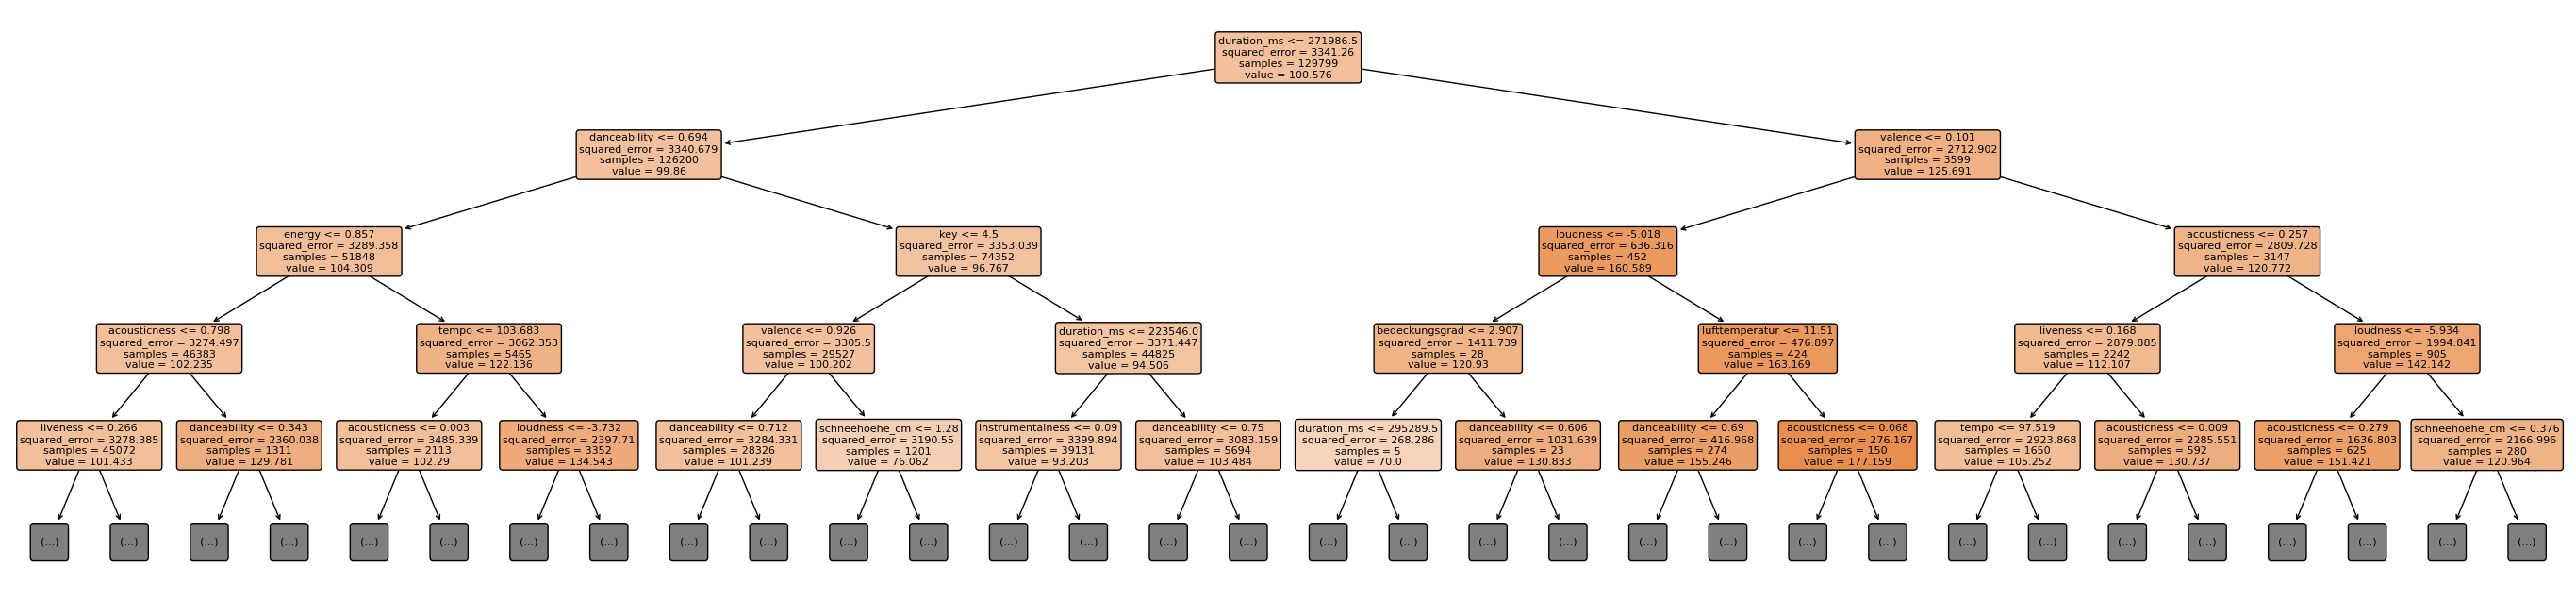

In [52]:
plt.figure(figsize=(35,8))
tree.plot_tree(rfr.estimators_[0],
               max_depth = 4,
               feature_names=x_df.columns.values,
               fontsize=8,
               filled=True,
               rounded=True)
plt.show()

The figure above details the first 5 layers of one of the decision trees in the Random Forest (the full tree is much more deep and complex).

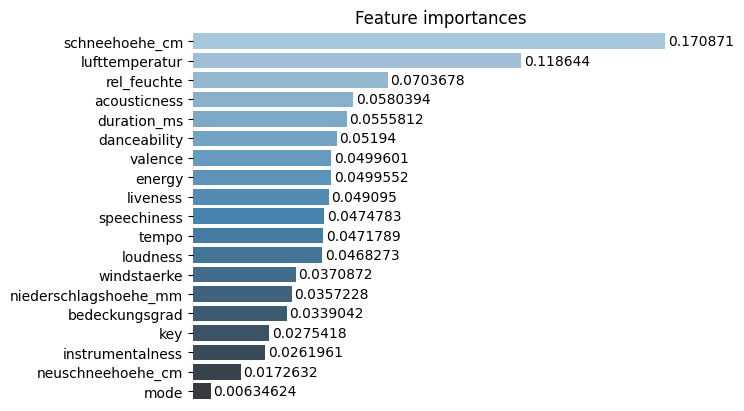

In [53]:
# visualize ranking of feature importances
features_df = pd.DataFrame({"features": rfr.feature_names_in_, "importances": rfr.feature_importances_ })
features_df_sorted = features_df.sort_values(by="importances", ascending=False)

plot = sns.barplot(data=features_df_sorted, x="importances", y ="features", palette="Blues_d")
sns.despine(bottom = True, left = True)
plot.set_title("Feature importances")
plot.set(xlabel=None)
plot.set(ylabel=None)
plot.set(xticks=[])
for container in plot.containers:
    plot.bar_label(container, padding=2)
plt.show()

Here, the relative importance of each feature in the Random Forest is visualized in a bar chart. The most important features are *snow height*, *air temperature* and *relative humidity*.

## 6. Get current weather and song data
In this section, I will retrieve the songs currently trending on Spotify in Germany through the [Top 50 - Germany playlist](https://open.spotify.com/playlist/37i9dQZEVXbJiZcmkrIHGU). Additionally, I will get the latest weather data for Germany from the [DWD's open data portal](https://opendata.dwd.de/). This is done in preparation for the final step of this project, which is to recommend a song based on the current weather using the RFR.

- Get current weather
- Get Spotify's top songs for today in Germany
- Merge the DataFrames
- Reorder columns

In [54]:
# get current weather
FTP_URI: str = "opendata.dwd.de"
path_rain = "climate_environment/CDC/observations_germany/climate/daily/more_precip/recent/"
path_cloud = "climate_environment/CDC/observations_germany/climate/subdaily/cloudiness/recent/"
path_temperature = "climate_environment/CDC/observations_germany/climate/subdaily/air_temperature/recent/"
path_wind = "climate_environment/CDC/observations_germany/climate/subdaily/wind/recent/"

def get_dwd_data(data_src_name: str, path: str):
    df = None
    ftp = FTP(FTP_URI, timeout=20)
    ftp.login()
    directory_path, file_name = os.path.split(path)
    ftp.cwd(directory_path)

    # Get a list of all files
    files = ftp.nlst()

    # Create target directory
    raw_data_directory: str = os.path.join("temp", data_src_name)
    os.makedirs(raw_data_directory, exist_ok=True)

    # Download each file
    for file in files:
        local_filename: str = os.path.join(raw_data_directory, file)
        with open(local_filename, "wb") as f:
            def callback(chunk):
                f.write(chunk)
            ftp.retrbinary("RETR " + file, callback)
    ftp.quit()

    # Get a list of all zip files in the directory
    zip_files = [file for file in os.listdir(raw_data_directory) if file.endswith(".zip")]
    for zip_file in zip_files:
        zip_path = os.path.join(raw_data_directory, zip_file)
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            # Get a list of member files contained in the zip file (excluding metadata files)
            member_files = [member for member in zip_ref.namelist() if not member.startswith("Metadaten_")]
            for member in member_files:
                # Read each member file into a DataFrame
                with zip_ref.open(name=member, mode="r") as tmpfile:
                    df = pd.read_csv(tmpfile, sep=";")
                    # Convert MESS_DATUM column to datetime format
                    try:
                        df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d%H")
                    except:
                        df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d")

    # delete temp directory
    shutil.rmtree(raw_data_directory)

    return df

def preprocess(df):
    df.replace(-999, pd.NA, inplace=True)
    df["date"] = pd.to_datetime(df["MESS_DATUM"]).dt.date
    df.drop(["MESS_DATUM", "eor"], axis=1, inplace=True)
    df = df.groupby("date").mean().reset_index()
    return df

In [55]:
# NOTE: this data is usually a few hours old because the DWD does not update it more frequently
rain_today_df = get_dwd_data("rain", path_rain)
rain_today_df = preprocess(rain_today_df)

cloud_today_df = get_dwd_data("cloud", path_cloud)
cloud_today_df = preprocess(cloud_today_df)

temperature_today_df = get_dwd_data("temperature", path_temperature)
temperature_today_df = preprocess(temperature_today_df)

wind_today_df = get_dwd_data("wind", path_wind)
wind_today_df = preprocess(wind_today_df)

In [56]:
weather_today_df = rain_today_df
weather_today_df = weather_today_df.merge(cloud_today_df, on="date", suffixes=("_rain", "_cloud"))
weather_today_df = weather_today_df.merge(temperature_today_df, on="date", suffixes=("_cloud", "_temp"))
weather_today_df = weather_today_df.merge(wind_today_df, on="date", suffixes=("_temp", "_wind"))

weather_today_df.drop(columns=["QN_6", " RSF", "QN_4_cloud", "CD_TER", "QN_4_temp", "QN_4", "DK_TER"], inplace=True)
weather_today_df.rename(columns={"  RS": "niederschlagshoehe_mm", "SH_TAG": "schneehoehe_cm", "NSH_TAG": "neuschneehoehe_cm", "N_TER": "bedeckungsgrad", "TT_TER": "lufttemperatur", "RF_TER": "rel_feuchte", "FK_TER": "windstaerke"}, inplace=True)

# drop rows containing NaNs (sometimes only part of the data for a day is available, forcing me to drop the entire row)
weather_today_df.dropna(inplace=True, subset=["bedeckungsgrad", "niederschlagshoehe_mm", "schneehoehe_cm", "neuschneehoehe_cm", "lufttemperatur", "rel_feuchte", "windstaerke"])
# only keep most recent date
weather_today_df = weather_today_df[weather_today_df["date"] == weather_today_df["date"].max()]
most_recent_date = weather_today_df["date"].max()
weather_today_df.drop(columns=["date"], inplace=True)

In [57]:
# get spotify's top songs for today in DE
lines = open("../data/spotify_credentials.txt", "r").readlines()
SPOTIFY_CLIENT_ID = lines[0].strip()
SPOTIFY_CLIENT_SECRET = lines[1].strip()
auth_manager = spotipy.oauth2.SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=auth_manager)

top_50_germany_id = "37i9dQZEVXbJiZcmkrIHGU"
playlist = sp.playlist_items(top_50_germany_id)
playlist_uris = [item["track"]["uri"] for item in playlist["items"]]

new_features = sp.audio_features(playlist_uris)
new_features_df = pd.DataFrame.from_dict(new_features)
new_features_df.drop(columns=["type", "id", "uri", "track_href", "analysis_url", "time_signature"], inplace=True)

In [58]:
# crossjoin weather and audio features
today_df = weather_today_df.merge(new_features_df, how="cross")
# reorder columns
today_df = today_df[["bedeckungsgrad", "niederschlagshoehe_mm", "schneehoehe_cm", "neuschneehoehe_cm", "lufttemperatur", "rel_feuchte", "windstaerke", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "valence"]]

## 7. Run song recommender
Generate predictions for the top songs for today and identify the highest predicted song ranking.

In [59]:
# generate a prediction for the top songs for today
today_pred = rfr.predict(today_df)

# get the highest predicted song ranking
best_pred_position = today_pred.argmin()

print(f"[latest weather data is from {most_recent_date}]")
print(f"The model recommends \"{playlist['items'][best_pred_position]['track']['name']}\" " \
    f"by {playlist['items'][best_pred_position]['track']['artists'][0]['name']} " \
    f"(predicted position {today_pred[best_pred_position]}).")

# show embed
track_id = playlist["items"][best_pred_position]["track"]["id"]
spotify_embed_url = f"https://open.spotify.com/embed/track/{track_id}"
display.display(display.IFrame(spotify_embed_url, width=700, height=200))

[latest weather data is from 2023-07-02]
The model recommends "Wildberry Lillet" by Nina Chuba (predicted position 99.76).


## 8. Clustering
In this section, I aim to cluster and visualize the audio features using [K-means](https://en.wikipedia.org/wiki/K-means_clustering) and [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). The goal is to identify distinct groups of songs that share similar audio features.

In [60]:
# Convert the audio features dataframe to a numpy array
selected_cols = ["acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo"]
data = audio_features_df[selected_cols].values

# normalize
scaler = StandardScaler()
data = scaler.fit_transform(data)

Linear models, such as Kmeans, are to susceptible to outliers and imbalance. normalization is necessary to counteract this.

[1219.8597068525844, 1013.039074234615, 1038.990329448822, 997.6025042198407, 964.8294295038795, 935.2655666892014, 887.1898106525299, 854.5982301226918, 815.8810132528105, 789.5739439999833]
Optimal number of clusters: 2


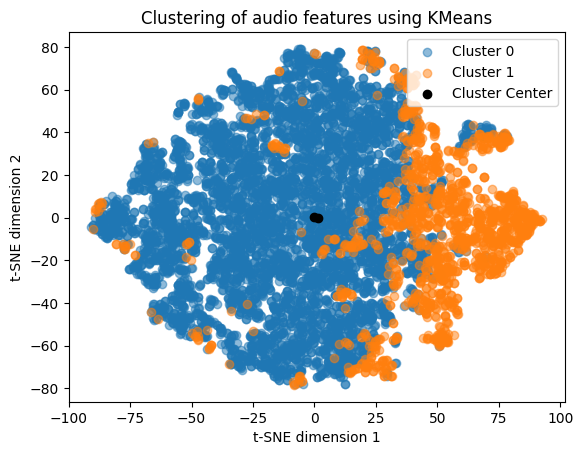

In [61]:
# Determine the optimal number of clusters using Calinski-Harabasz index
calinski_scores = []
for n_clusters in range(2, 12):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
    labels = kmeans.fit_predict(data)
    calinski_scores.append(calinski_harabasz_score(data, labels))

optimal_n_clusters = np.argmax(calinski_scores) + 2  # Add 2 because range started at 2!

print(calinski_scores)
print(f"Optimal number of clusters: {optimal_n_clusters}")

# Perform KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=0, n_init="auto")
labels = kmeans.fit_predict(data)

# Get center points of each cluster
cluster_centers = kmeans.cluster_centers_

# Visualize the clusters using t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(data)

# Plot
for label in np.unique(labels):
    cluster_points = tsne_data[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=.5, label=f"Cluster {label}")

# Highlight mean points
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c="black", label="Cluster Center")

plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.title("Clustering of audio features using KMeans")
plt.legend()
plt.show()


The resulting visualization does not provide clear and distinct clusters. I suspect this is in part due to the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) and in part due to a lack of distinct groups in the first place. It may be possible to improve the results by tuning the hyperparameters of the algorithm, but this is beyond the scope of this project.

## 9. Conclusion and outlook
In this project, I have explored the potential connection between music preferences and weather conditions. While some patterns were observed, it is important to note that these associations were not statistically significant. Adding further evidence to this, the clustering was not able to find distinct groups in the data either. Future projects could benefit from more granular data, such as music charts specific to smaller regions or individual cities.  

Cultural context it is worth considering as a major influence on music preferences. The current observation period exists within a post-modernist environment created by a hyperfragmentation of media which caused the absence of a dominant artistic and cultural movement. Consequently, the subtle patterns in music and weather may not be as recognizable as they would be in a more homogenous cultural setting. A potential avenue to investigate that hypothesis could be to compare the findings of this project with music from a more distinct cultural era such as the 1970s or 1980s.  

In any case, these results lead me to suspect that the drivers of music preferences are influenced by multiple factors, and the impact of weather is only minor.